In [ ]:
from huggingface_hub import list_datasets, login
token = ""
login(token=token)

## The Dataset

In [1]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [2]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [3]:
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

To make a realistic Swiss corpus, we'll sample the German (de), French (fr), Italian (it), and English (en) corpora from PAN-X according to their spoken proportions.

In [4]:
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
        )

In [5]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


Let's inspect one of the examples in German corpus

In [6]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [10]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [11]:
# Calculate frequencies of each entity across each split
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split('-')[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# A Closer Look at Tokenization

XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages.

In [12]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [13]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()
print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


## The SentencePiece Tokenizer

Based on a type of subword segmentation called Unigram and encodes each input text as a sequence of Unicode characters. SentencePiece is agnostic about accents, punctuation, and the fact that many languages do not have whitespace characters.

In [14]:
"".join(xlmr_tokens).replace(u'\u2581', " ")

'<s> Jack Sparrow loves New York!</s>'

# Transformers for Named Entity Recognition

# Creating a Custom Model for Token Classification

To get started, we need a data structure that will represent out XLM-R NER tagger. We'll need a configuration object to initialize the model and a *forward()* function to generate the outputs.

In [15]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

class XLMRobertaFortokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representations
        sequence_output = self.dropout(outputs[0]) # get tensor of output
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states= outputs.hidden_states, 
                                     attentions=outputs.attentions)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

## Loading a Custom Model

We'll need to provide some additional information beyond the model name, including the tags that we will use to label each entity and the mapping of each tag to an ID and vice versa.

In [16]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [17]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

The *AutoConfig* class contains the blueprint of a model's architecture. If we want to modify something like the number of classes or label names, then we can load the configuration first with the parameters we would like to customize.

Now, we can load the model weights as useual with the *from_pretained()* with the additional *config* argument.

In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaFortokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device)
             )

Some weights of XLMRobertaFortokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["tokens", "input IDs"])

,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


Finally, we need to pass the inputs to the model and extract the predictions by taking the argmax to get the most likely class per token

In [20]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [21]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens","Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,O,O,O,O,O,O,O,O,I-ORG


Unsurprisingly, our token classification layer with random weights leaves a lot to be desired; let's fine-tune on some **labeled data** to make it better! Before doing so, let0s wrap the preceding steps into a helper function for later use

In [22]:
def tag_text(text, tags, model, tokenizer):
    # Get tokenizer with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    inputs = xlmr_tokenizer.encode(text, return_tensors="pt").to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(inputs)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens","Tags"])

Before we can train the model we also need to tokenize the inputs and prepare the labels.

## Tokenizing Texts for NER

In [23]:
words, labels = de_example["tokens"], de_example["ner_tags"]
print(words)
print(labels)
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [24]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens","Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [25]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l !=-100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [26]:
# simple function that wraps all the logic
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs        

Now we have all the ingredients we need to encode each split, so let's write a function we can iterate over:

In [27]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs','ner_tags','tokens'])

In [28]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

## Performance Measures

The only subtlety is that *all* words of an enity need to be predicted correctly in order for a prediction to be counted as correct.

In [29]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [30]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx, seq_idx]])
                example_preds.append(index2tag[preds[batch_idx, seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-tuning XLM-RoBERTa

Our first strategy will be to fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian and English.

In [31]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=1e-2, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
from huggingface_hub import notebook_login

notebook_login()

We also need to tell the *Trainer* how to compute metrics on the validation set, se here we can use the *align_predictions()* function to extract the predictions and labels in the format needed by *seqeval* to calculate the F1-score

In [33]:
from seqeval.metrics import f1_score
from pprint import pprint

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

The final step is to define a **data collator** so we can pad each input sequence to the largest sequence length in a batch.

Padding the labels is necessary because, unlike in a text classification task, the labels are also sequences. One important detail here is that the label sequences are padded with the value -100, which is **ignored by Pytorch loss functions**

In [34]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

We'll avoid inititlizing a new model for every *Trainer* by creating a *model_init()* method. This method loads an untrained model and is called at the beginning of the *train()* call

In [35]:
def model_init():
    return (XLMRobertaFortokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [36]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

/tmp/ipykernel_821402/3874884814.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Expl

In [37]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid de

Epoch,Training Loss,Validation Loss,F1
1,0.259100,0.156135,0.816176
2,0.126800,0.141753,0.848825
3,0.079700,0.139702,0.862832


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-de/commit/2e1db36b300f9555d227aab8b91eb51022d7b916', commit_message='Training completed!', commit_description='', oid='2e1db36b300f9555d227aab8b91eb51022d7b916', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/xlm-roberta-base-finetuned-panx-de'), pr_revision=None, pr_num=None)

Let's test it on the German translation of our simple example:

In [38]:
text_de = "Jeff Dwan is ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁D,wan,▁is,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


It works! But we should never get too confident about performance based on a single example.
We should conduct a proper and thorough investigation of the model's errors.

## Error Analysis

Examples where training can fail include:

- We might accidentally mask too many tokens and also mask some of our labels to get a really promissing loss drop.
- The *compute_metrics()* function might have a bug that overestimates the true performance.
- We might include the zero class or *O* entity in NER as a normal class, which will heavily skew the accuracy and F1-score since it is the majority class by a large margin.

When the model performs much worse than expected, looking at the errors can yield useful insights and reveal bugs that would be hard to spot ny just looking at the code.
These are aspects we always need to keep in mind when we deploy a model in a production environment.

We will look at the validation examples with the highest loss. We'll now calculate a loss per token in the sample sequence.

In [39]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [BS, SEQ_LEN, CLASSES]
        num_classes = output.logits.shape[-1]
        # predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, num_classes), # 7 because is the number of classes ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]
                         labels.view(-1), reduction="none")
    # unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss": loss,
            "predicted_label": predicted_label}

In [40]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Tokens and labels are still encoded with their IDs.
For the padding tokens -100 we assign a special label, IGN, so we can filter them later.
We also get rid of all the padding in the *loss* and *predicted_label* fields by truncating them to the length of the inputs:

In [41]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
# truncate to the length of the inputs
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x['input_ids'])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x['input_ids'])], axis=1)

df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.007227821, 0.0, 0.009881509, 0.0081332...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.0052162027, 0.0, 0.0, 0.0, 0.0, 1.3796...","[O, O, O, O, O, O, B-LOC, I-LOC, I-LOC, I-LOC,...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.0001296913, 8.093983e-05, 0.0001144343...","[O, O, O, O, O, B-ORG, O, I-ORG, O, O, O, O, O...","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00015603278, 0.00012444676, 0.00014292...","[B-LOC, O, O, O, B-LOC, I-LOC, O, O, B-LOC]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 8.7972585e-05, 9.083335e-05, 9.6078074e-...","[B-ORG, O, O, O, O, O, O, O, O, O, O, O, B-ORG...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


Let's have a look at the tokens individually by unpacking these lists. The *pandas.Series.explode()* function allows us to do exactly that in one line by creating a row for each element in the original rows list.
We also drop the padding tokens we named IGN, since their loss is zero anyway.

In [42]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.01,O,▁WE
1,83982,1,B-ORG,1.38,B-LOC,▁Luz
1,10,1,I-ORG,1.38,I-LOC,▁a


With the data in this shape, we can now group it by the input tokens and aggregate the losses for each token with the count, mean, and sum. Finally, we sort the aggregated data by the sum of the losses and see which tokens have accumulated the most loss in the validation set:

In [43]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # get rid of the multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(20)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁'',▁(,▁),▁A,▁die,▁des,▁West,▁D,▁Ober,▁',▁I,▁de,▁Frauen,▁T
count,6066,1388,989,808,163,1171,2898,246,246,125,860,366,48,89,27,2133,94,139,15,37
mean,0.04,0.1,0.13,0.15,0.69,0.08,0.03,0.31,0.29,0.5,0.06,0.13,0.95,0.48,1.41,0.02,0.38,0.24,2.18,0.85
sum,222.05,133.15,127.78,122.97,112.25,97.15,77.97,76.29,71.62,62.17,53.49,47.41,45.44,42.36,38.11,36.48,35.84,33.66,32.74,31.36


We can observe several patterns in this list:

- The whitespace token has the highest total loss, which is not surprising since it is also the most common token in the list.
- Words like "in", "von", "der" and "und" appear relatively frequently. They often appear together with named entities and are sometimes part of them, which explains why the model might mix them up.
- Parentheses, slashes, and capital letters at the beginning of words are rarer but have a relatively high average loss. We will investigate them later.

In [44]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # get rid of the multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-ORG,B-ORG,O,B-LOC,I-LOC,I-PER,B-PER
count,3820,2683,43648,3172,1462,4139,2893
mean,0.51,0.63,0.03,0.33,0.62,0.2,0.27
sum,1941.2,1689.14,1372.92,1054.5,911.25,840.11,782.29


*B-ORG* has the highest average loss, which means that detemining the beginning of an organization poses a challenge to our model.

Confusion matrix of the token classification:

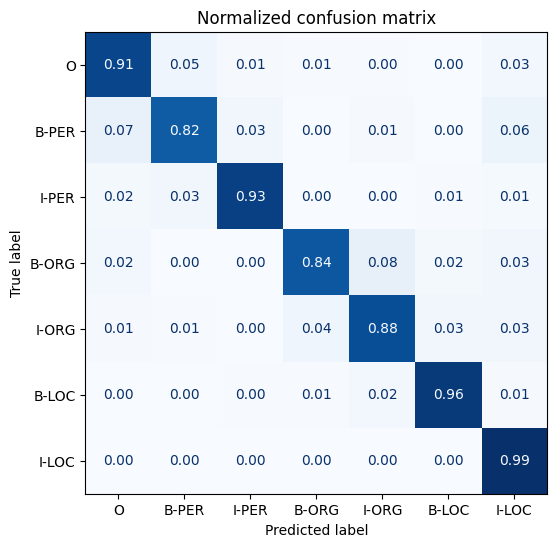

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

Let's look at sequences with high losses.

Calculate the total loss by summing over the loss per token. Let's write a function that helps us display the token sequences with the labels and the losses:

In [46]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                              "preds": preds, "losses": losses}).T
        yield df_tmp

In [47]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,2.40,0.00,0.00,0.00,11.40,9.78,6.70,7.93,7.62,0.00,8.51,8.60,0.00,9.28,8.84,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.47,0.00,0.00,9.21,9.92,10.01,7.29,0.00,6.55,8.43,7.32,5.94,5.10,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.78,6.61,6.35,0.00,6.40,0.00,6.41,0.00,6.20,5.83,5.79,5.85,6.29,5.95,0.00


Another thing we can notice is that parentheses and slashes have a relatively high loss.

In [48]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(5)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00


,0,1,2,3,4,5,6,7,8,9,10,11
tokens,▁Pik,e,▁Town,ship,▁(,▁Brown,▁County,▁,",",▁Ohio,▁),</s>
labels,B-LOC,IGN,I-LOC,IGN,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00


,0,1,2,3,4,5,6
tokens,▁Bad,▁Grund,▁(,▁Har,z,▁),</s>
labels,B-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.03,0.02,0.02,0.02,0.00,0.02,0.00


,0,1,2,3,4,5,6,7,8
tokens,▁Al,fon,s,▁VI,.,▁(,▁León,▁),</s>
labels,B-PER,IGN,IGN,I-PER,IGN,I-PER,I-PER,I-PER,IGN
preds,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We've identified some weaknesses in both our model and the dataset. In a real use case we would iterate on this step, cleaning up the dataset, retraining the model, and analyzing the new errors until we were satisfied with the performance.

We'll perform some experiments to see how well the cross-lingual transfer in XLM-R works.

# Cross-Lingual Transfer

Now that we have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages via the *predict()* method.

In [49]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [50]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.863


In [51]:
# Model fine-tuned on German on French:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [52]:
# German model on whole French test set
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.698


In [53]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.670


In [54]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.584


# When Does Zero-Shot Transfer Make Sense?

In [55]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
                     data_collator=data_collator, compute_metrics=compute_metrics,
                     train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]}
    )

In [56]:
# Encode French corpus into IDs
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

In [57]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.626900,1.301510,0.015905
2,1.195200,0.978810,0.200309
3,0.926600,0.889560,0.349954


,num_samples,f1_score
0,250,0.359977


In [58]:
metrics_df = pd.concat(
    [
        metrics_df,
        *[train_on_subset(panx_fr_encoded, num_samples) for num_samples in [500, 1000, 2000, 4000]]
    ],
    ignore_index=True
)

/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.436900,0.929560,0.350160
2,0.793000,0.602746,0.608884
3,0.528100,0.517416,0.666772


/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.093500,0.560990,0.644444
2,0.473000,0.420323,0.737734
3,0.296900,0.372421,0.779006


/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.778400,0.431334,0.707871
2,0.325200,0.373198,0.762550
3,0.217300,0.343487,0.801942


/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.573700,0.344700,0.802541
2,0.279200,0.304629,0.818441
3,0.175200,0.288018,0.832635


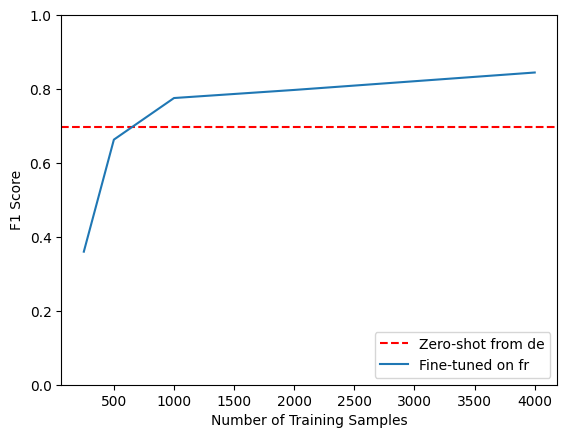

In [59]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

From the plot we can see that zero-shot transfer remains competitive until about 750 training examples. Nevertheless, this result is not to be sniffed at! Getting domain experts to label even hundreds of documents can be costly, especially for NER, where the labelling process is fine-grained and time-consuming.

There is one final technique we can try to evaulate multilingual learining; **fine-tuning on multiple languages at once!**

## Fine-Tuning on Muliple Languages at Once

One way of mitigating the drop in performance is by fine-tuning on multiple languages at the same time. *concatenate_datasets()* function to concatenate the German and French corpora:

In [60]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)
    return multi_corpus

In [61]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [62]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"]
                 )
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/tmp/ipykernel_821402/3938588869.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.280500,0.176874,0.825428
2,0.145900,0.164877,0.847113
3,0.094300,0.162401,0.859845


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-de-fr/commit/b7e96476e1e07460ae3ee8b3e794971ae8cd8323', commit_message='Training completed!', commit_description='', oid='b7e96476e1e07460ae3ee8b3e794971ae8cd8323', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-de-fr', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/xlm-roberta-base-finetuned-panx-de-fr'), pr_revision=None, pr_num=None)

In [63]:
# Let's have a look at how the model perfroms on the test set of each language
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.869


F1-score of [de-fr] model on [fr] dataset: 0.862


F1-score of [de-fr] model on [it] dataset: 0.792


F1-score of [de-fr] model on [en] dataset: 0.675


Comparing the performance of fine-tuning on each language separately against multilingual learning on all the corpora.

In [64]:
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.585900,0.335840,0.781302
2,0.278800,0.277782,0.815062
3,0.186900,0.279908,0.841981


/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.723900,0.323580,0.740566
2,0.284200,0.258414,0.789686
3,0.179300,0.266015,0.816878


/tmp/ipykernel_821402/284266965.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.022000,0.510650,0.579459
2,0.477200,0.416828,0.649394
3,0.363000,0.385773,0.685144


Now that we've fine-tuned on each language's corpus, the next step is to concatenate all the splits together to create a multilingual corpus of all four languages.

In [67]:
corpora_encoded = concatenate_splits(corpora)

In [69]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                 data_collator=data_collator, compute_metrics=compute_metrics,
                 tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                 eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/tmp/ipykernel_821402/2911492552.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,0.295900,0.200548,0.807489
2,0.156600,0.170836,0.840577
3,0.102400,0.176252,0.855366


CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-all/commit/c9887112915afc82b14cd6a01d1f8eafbea3939e', commit_message='Training completed!', commit_description='', oid='c9887112915afc82b14cd6a01d1f8eafbea3939e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

In [73]:
# Generate the predictions from the trainer on eac language's test set
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
              "all": f1_scores["all"]}

In [74]:
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                        inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8635,0.6980,0.6703,0.5840
each,0.8635,0.8448,0.8150,0.6845
all,0.8644,0.8672,0.8713,0.7503


- Multilingual learning can provide significant gains in performance, especially if the low-resource languages for cross-lingual transfer belong to similar language families.
- As a general strategy, focus the attention on cross-lingual transfer *within* language families.

# Conclusion

- NLP task on a multilingual corpus using a single transformer pretrained on 100 languages: XLM-R
- Cross-lingual transfer from German to French is competitive when only a small number of labeled examples ara available for fine-tuning. This good performance generally does not occur if the target language is significantly different from the one the base model was fine-tuned.
- So far we have looked at two tasks: sequence classification and token classification. Both fall into the domain of Natural Language Understanding, where text is synthetized into predictions.